# Neural networks and Reservoir Computing

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

## Introduction

In this lecture we will cover the following topics:

- Windowed approaches and nonlinear models for time series forecasting.
- Neural networks and the Multi-Layer Perceptron.
- A brief overview of Recurrent Neural Networks.
- The ESN, a randomized RNN from the family of Reservoir Computing.
- An introduction to dimensionality reduction with Principal Component Analysis.
- Examples of forecasting with MLP and ESN on real-world electricity data.

In [31]:
import sys

# Install dependencies if the notebook is running in Colab
if 'google.colab' in sys.modules:
    !pip install -U -qq reservoir_computing

In [32]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.datasets import make_circles
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.utils import make_forecasting_dataset
from reservoir_computing.datasets import PredLoader

---

## Windowed approaches for prediction

- These methods consider a fixed window of size $P$.
- Use the elements of the time series within the window $x(t-P), \dots, x(t-1), x(t)$ to compute the prediction $x(t+\tau)$, where $\tau$ is the forecasting horizon.
- Different algorithms combine the elements of the window in different ways to make predictions.

<img src="media/windowed.png" style="width: 40%; display: block; margin: auto;">

- As the window slides along the time series, new predictions are made.
- An example of windowed approach is the linear AR model of order $P$: 

$$\hat y(t+1) = \beta_0 + \beta_1 x(t-1) + \beta_2 x(t-2) + \dots + \beta_P x(t-P)+\epsilon_t$$

<img src="media/sin.gif" style="width: 40%; display: block; margin: auto;">

### Limitation of linear models

- Linear models are widely used for their simplicity and interpretiveness. 
- However, they assume a constant relationship between input and target variables.
- As such, they cannot capture these nonlinearities and interactions effectively. 

- Consider the following examples:
  1. Compute the *position* $y$ of a robotic arm given the positions $x_1, x_2, \dots$ of the joints.
  2. Compute a trajectory $\dot{y}$ given the angular velocities $\omega_1, \omega_2, \dots$ of the joints. 

<img src="media/robot.png" style="width: 40%; display: block; margin: auto;">

- A linear model will fail in the second task.

#### Example: forecasting electricity demand

- This is a classic example where linear models fail.
- Electricity demand is often governed by complex and nonlinear interactions with other factors.

**Temperature and Demand**
- The relationship between temperature and electricity demand is typically nonlinear and can exhibit a U-shaped curve. 
- Demand is low at moderate temperatures but increases sharply at high or low temperatures due to heating and cooling needs.

**Time and Demand**
- Demand patterns vary significantly throughout:
  - the day (peak hours in the morning and evening),
  - week (workdays vs. weekends),
  - year (summer vs. winter).

### Advantages of Nonlinear Models

- Nonlinear models, such as neural networks, SVM, tree-based methods, etc..., can:
  - model the nonlinear relationships between demand and factors like temperature, capturing the U-shaped curve accurately,
  - take into account the interactions between different variables, such as the combined effect of time, holidays, and temperature on demand,
  - adapt to various patterns and changes in trends over time, making them more robust in dynamic environments.

---

## Neural networks

- Neural Nets are powerful nonlinear models that are *universal approximators*, i.e., they can learn to approximate any function.
- Basic idea:
  1. Map the data into a high dimensional space (bless of dimensionality).
  2. Apply a nonlinear transformation.
  3. Data become linearly separable.

In [33]:
def plot_3D(elev=20, azim=30):
    X, y = make_circles(n_samples=200, factor=.01, noise=.15)
    fig = plt.figure(figsize=(10, 5))
    r = np.exp(-(X ** 2).sum(1))
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='bwr', alpha=0.5)
    ax.view_init(elev=elev, azim=azim)
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
    zz = np.full(xx.shape, 0.6)
    ax.plot_surface(xx, yy, zz, color='grey', alpha=0.7)
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_zlabel("$z_3$")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_zticks(())
    ax2 = fig.add_subplot(1, 2, 1)
    ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr', alpha=0.5)
    ax2.set_xlabel("$x_1$")
    ax2.set_ylabel("$x_2$")
    ax2.set_xticks(())
    ax2.set_yticks(())
    plt.tight_layout()
    plt.show()

- This figure illustrates how mapping the data from a lower dimension (2D) to a higher dimension (3D) and applying a nonlinear function makes data linearly separable by an hyperplane.

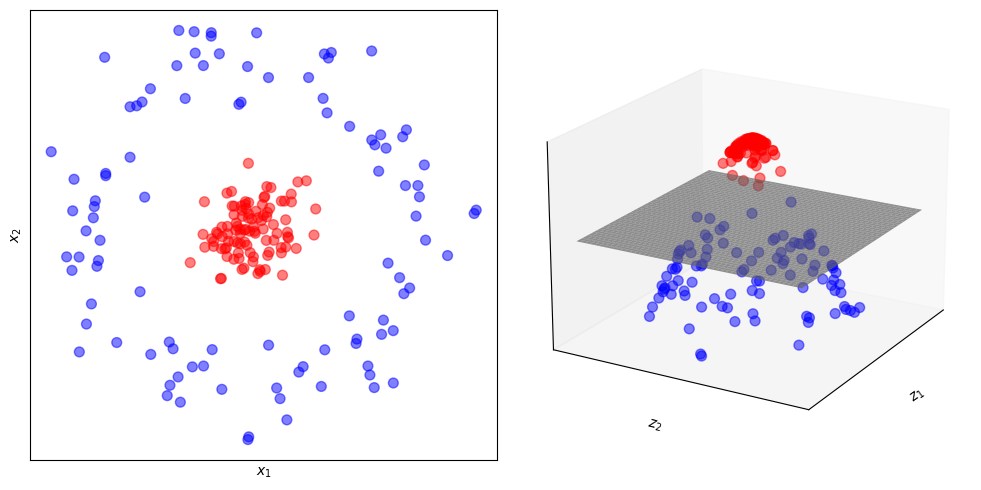

In [34]:
plot_3D()

### Multi-Layer Perceptron

- A Multi-Layer Perceptron (MLP) is a simple Neural Network that consists of at least three layers of nodes: 
  - An input layer.
  - One or more hidden layers.
  - An output layer. 
- The nodes in the a hidden layers apply a nonlinear activation function $\sigma$. 
- MLP are generally trained with a supervised learing technique called backpropagation.

- The MLP's layers are fully connected, meaning each node in one layer connects with a certain weight to every node in the following layer. 
- The first layer receives the input.
- The output of each layer is the input for the next layer until the final layer produces the output of the MLP.
- The weights are stored in matrices $W$ and are the trainable parameters of the model.
- The MLP can learn complex mappings from inputs to outputs to perform a wide range of data modeling and prediction tasks.

#### Example: a simple MLP

- Let's consider a concrete example of an MLP with one input layer, two hidden layers (with $h_1$ and $h_2$ units respectively), and one output layer. 
- The input vectors are of size $d_\text{in}$, and the output vectors are of size $d_\text{out}$.

<img src="media/mlp.png" style="width: 40%; display: block; margin: auto;">

**Input layer**
- The size of the input layer corresponds to the size of the input vectors, $d_\text{in}$. 
- This layer simply passes the input to the first hidden layer without applying any transformation.

**First hidden layer**
- This layer has $h_1$ nodes. 
- Each node connects to all the $d_{\text{in}}$ inputs.
- It applies a weight matrix $W_\text{in} \in \mathbb{R}^{d_\text{in} \times h_1}$ that transforms the input from vectors in $\mathbb{R}^{d_\text{in}}$ to vectors in $\mathbb{R}^{h_1}$.
- Then, it applies a nonlinear activation function $\sigma$, and outputs $h_1$ intermediate results.

**Second hidden layer**

- This layer has $h_2$ nodes. 
- It takes the $h_1$ outputs from the first hidden layer. 
- It applies another set of weights and a nonlinear activation function to produce $h_2$ intermediate results.

**Output Layer**
- The output layer has $d_\text{out}$ units. 
- It takes the $h_2$ outputs from the second hidden layer, applies weights and possibly a different activation function that depends on the task (usually, softmax for classification or no activation for regression).
- The final output vector is of size $d_\text{out}$.

### MLP for time series forecasting

- The MLP can be used as a windowed technique to perform time series forecasting.
- The sequence of past values $x(t-P), \dots, x(t-1), x(t)$ will represent our input vector ($d_\text{in} = P$).
- The future value $x(t+\tau)$ will be the output that the model will learn to predict ($d_\text{out} = 1$).
- We can also train the MLP to predict a sequence of $d_\text{out} = H$ future predictions, e.g., $x(t+\tau), x(t+\tau+1), \dots, x(t+\tau+H)$.

<img src="media/mlp_windowed.png" style="width: 40%; display: block; margin: auto;">

- Key for the training of the MLP is the creation of input-output pairs $\{\mathbf{x}_i, \mathbf{y}_i\}$ used for training.
- Given the input $\mathbf{x}_i$ the model must learn to predict the output $\mathbf{y}_i$.
- This is done by adapting the model weights to minimize the discrepancy between the prediction $\mathbf{\hat y}_i$ and the desired output $\mathbf{y}_i$.
- The weights are modified according to the gradient taken with respect to a loss function $\mathcal{L}(\mathbf{\hat y}_i, \mathbf{y}_i)$ such as the MSE, e.g., $W \leftarrow W + \delta \frac{\partial \mathcal{L}}{\partial W}$.
- $\delta$ is a small constant defining the gradient step (learning rate).

- Given the chunk of time series used for training, the training samples are generated according to the scheme in the picture.
- Each input-output pair consists of:
    - a window of past time series values $x(t-P), \dots, x(t-1), x(t)$.
    - a window of future values $x(t+\tau), x(t+\tau+1) \dots, x(t+\tau+H)$.
  
<img src="media/data_split.png" style="width: 100%; display: block; margin: auto;">

### Python example

- In this example we will consider a time series of electricity consumption registered on a backbone of the energy distribution network of Rome.
- The original time series has 10min resolution.
- For this example, we will resample it to 1h resolution as it will become more smooth (and easier to predict).
- To train our models faster, we will consider only the first `3000` samples.

In [35]:
ts_full = PredLoader().get_data('ElecRome')

# Resample the time series to hourly frequency
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)

# Use only the first 3000 time steps
time_series = ts_hourly[0:3000]
time_steps = np.arange(0, len(time_series))

Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)


- Next we split the data in train and test set.
- We simply use the first 90% as training and the rest as test.

In [36]:
# Split the time series into training and test sets
train_size = int(0.9*len(time_series))
tr = time_series[:train_size]
te = time_series[train_size:]

- Next, we define the function to create input-output pairs.
- For example, we create as input windows of size $P=12$ by specifying `window_size=12`.
- Similarly, we create as ouput windows of size `forecast_horizon=12`.
- If we are interested in predicting only one sample, e.g., $\tau=12$ and $H=1$, we simply take the last element of the output window.

In [37]:
def create_windows(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:i + window_size + forecast_horizon])
    return np.array(X), np.array(y)

# Define window size and forecast horizon
window_size = 12
forecast_horizon = 12

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

- We can see how the input-output pairs look like in the following plot.
- The blue dots will represent the input $x_{t-P}, \dots x_{t-1}, x_t$ with $P=12$.
- The orange dot is the output $x_{t+\tau}$ with $\tau=12$.

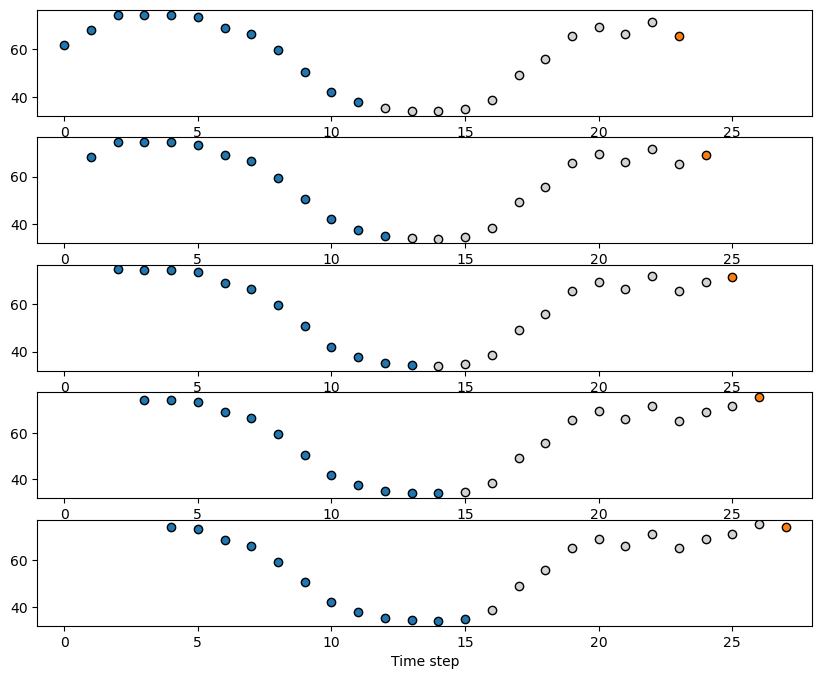

In [38]:
# Plot some pairs of input-output
fig, axes = plt.subplots(5,1,figsize=(10,8))
for i in range(5):
    axes[i].scatter(range(i, window_size+i), X_train[i], color='tab:blue', edgecolor='k')  # Input
    axes[i].scatter(range(window_size+i, i+window_size+forecast_horizon-1), y_train[i,:-1], color='lightgray', edgecolor='k') 
    axes[i].scatter(i+window_size+forecast_horizon-1, y_train[i,-1], color='tab:orange', edgecolor='k')
    axes[i].set_xlim(-1,28)
plt.xlabel('Time step')
plt.show()

- Let say we instead want to predict the energy consumption 1 day ahead by looking at the consumption of the previous 12 hours, which is a more realisitc scenario.
- We define `forecast_horizon = 24` to do that.

In [39]:
# Define window size and forecast horizon
window_size = 12
forecast_horizon = 24

# Create input-output pairs
X_train, y_train = create_windows(tr, window_size, forecast_horizon)
X_test, y_test = create_windows(te, window_size, forecast_horizon)

# We are only interested in the last time step of the horizon
y_train = y_train[:, -1]  
y_test = y_test[:, -1] 

- Most neural nets, including the MLP, want the data to be normalized in a small range.
- We can do that by applying the `StandardScaler()` from the sklearn library.
- `scaler.fit_transform(X_train)` will subtract from `X_train` its mean and divide by its variance.
- `scaler.transform(X_test)` will subtract from `X_test` the mean of `X_train` and divide by the variance of `X_train`. 
- Why not normalizing with the test set statistics?
    - Because we do not have access to the test data beforehand, so we cannot compute statistics such as its mean and variance.

In [40]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Next, we define the MLP.
- We specify the size of the hidden layers as $h_1=16$ and $h_2=8$. Using larger values increases the model capacity, but can lead to overfit.
- As the activation function we use a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).
- As the algorithms to compute the gradients and update the values of the parameters $W$ we use [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).
- Finally, we train the model for `1000` iterations.

In [41]:
# Define and train the neural network
mlp = MLPRegressor(hidden_layer_sizes=(16,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(16, 8), max_iter=1000)

- Once the model is trained, we can compute the prediction on the test set.
- We can also compute predictions beyond the whole dataset that we have available.
- In this case, we do not have a way to check how well the model is doing since we do not have the actual data available.
- However, it reflects a realistic forecasting scenario where we, indeed, do not know the future.

In [42]:
# Predict on the test set
y_pred = mlp.predict(X_test_scaled)

# Forecast beyond the dataset using the model
last_window = time_series[-window_size:]
last_window_scaled = scaler.transform(last_window.reshape(1, -1))
next_step_pred = mlp.predict(last_window_scaled)

print(f"The next time step prediction is {next_step_pred[0]:.2f}")

The next time step prediction is 32.85


- To check the performance of the model we can compute the MSE on the predictions of the test set.
- We can also visualize the predictions against the real data.

Mean Squared Error: 24.68


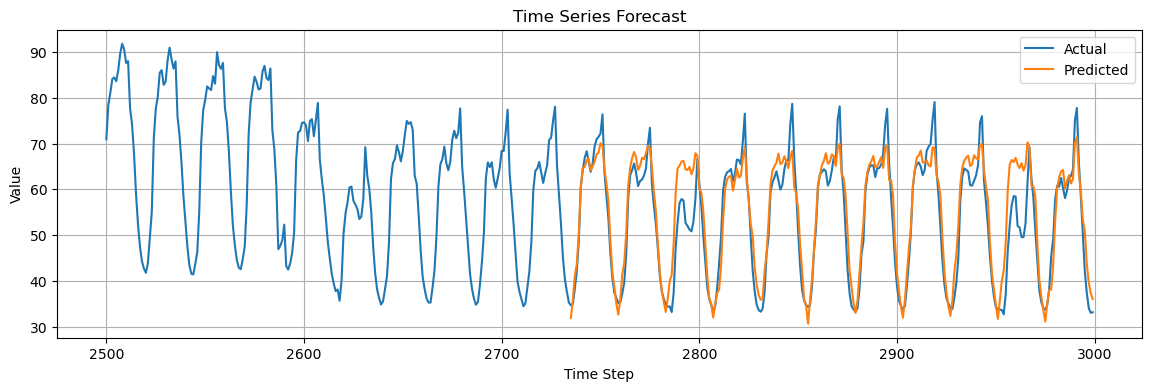

In [43]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

plt.figure(figsize=(14, 4))
plt.plot(time_steps[2500:], time_series[2500:], label="Actual")
plt.plot(time_steps[-len(y_test):], y_pred, label="Predicted")
plt.title("Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

- Is the prediction good or not?
- To get an idea, we can compare the performance against a simple baseline.
- In this case, we are making a prediction at a forecast horizon $\tau=24$ equal to the main seasonality of the time series.
- The most natural baseline is to use the values of the previous day as the prediction for the next day.

Mean Squared Error: 27.14


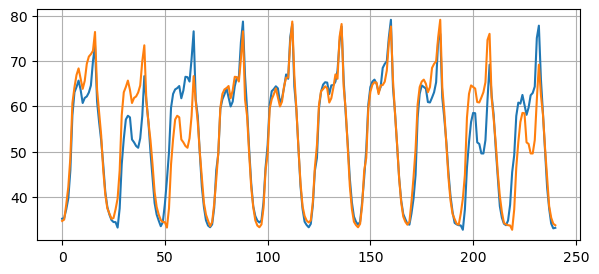

In [44]:
# Compute the mse between the original time series and the time series shifhted by 24 time steps
mse = mean_squared_error(y_test[24:], y_test[:-24])
print(f"Mean Squared Error: {mse:.2f}")

plt.figure(figsize=(7, 3))
plt.plot(y_test[24:])
plt.plot(y_test[:-24])
plt.grid()
plt.show()

- Any reasonable forecasting method must beat this baseline.

### Windowed approaches drawbacks

- What is the optimal value of $P$?
- If $P$ is fixed, how can we deal with different temporal dependencies?
- Let's consider the example of predicting the next word in a sentence.

<img src="media/word_pred.gif" style="width: 50%; display: block; margin: auto;">

- In the first case, we need to go back 4 time steps to retrieve the information we need.
- In the second case, 9 steps.
- How to set $P$? What is the maximum memory we will ever need? 
- As discussed previously, setting $P$ too high will smooth our data too much.
- Finding a good tradeoff is difficult...

---

## Recurrent Neural Networks

- RNNs are a class of neural networks designed to recognize patterns in sequences of data, such as time series data, natural language, or sequences of images. 
- Unlike traditional neural networks, RNNs have a memory that captures information about what has been calculated so far, essentially allowing them to make predictions based on past inputs.

- As an RNN processes a sequence $\mathbf{x}$ it maintains information in a *hidden state* $\mathbf{h}$. 
- This process allows the RNN to use previous computations as a context for making decisions about new data.
  
<img src="media/RNN.gif" style="width: 70%; display: block; margin: auto;">

- $x(t)$ is the input time series, $\mathbf{h}(t)$ the hidden state vector, $y(t)$ the output.
- The matrices $W_x$, $W_h$, and $W_o$ represents the input, hidden (recurrent), and output weights respectively.

**Back Propagation Through Time (BPTT)**

- BPTT is the algorithm used for training RNNs. 
- It involves unfolding the RNN through time to obtain a standard feed-forward neural network (like an MLP). 
- After unfolding, one can apply the standard backpropagation algorithm. 
- BPTT computes gradients for each parameter across *all* time steps of the input sequence. 

<img src="media/bptt.png" style="width: 50%; display: block; margin: auto;">

### Challenges and shortcomings in RNNs

- In BPTT the gradient has to go through all time steps and, due to the presence of nonlinearities, it can become too small and not reach distant time steps.
- This creates the problem called *vanishing gradient*. 
- Opposed, yet similar, is the problem of *exploding gradient* occurring when the gradients grow across the sequence. 
- The vanishing gradient problem makes it hard for RNNs to learn long-range dependencies because updates to the weights become insignificantly small, causing the learning to stall. 
- Conversely, exploding gradients can cause weights to oscillate or diverge.
- Techniques such as gradient clipping and gated units (e.g., LSTM, GRU) have been developed to mitigate these issues.

- Another important limitation of the RNNs is that they fail to exploit hardware acceleration like other neural nets.
- This is due to their recurrent nature that requires computations to be done sequentially rather than in parallel.

---

## Reservoir Computing

- RC is a familily of randomized RNNs, popularized in machine learning by Echo State Networks (ESNs).
- RC and ESNs are terms ofen used interchangeably.
- There are two main differences that separate an ESN from an RNN:

<img src="media/Reservoir.gif" style="width: 70%; display: block; margin: auto;">

- The output weights $W_o$ is the only part of the ESN that is trained.
- Optimizing $W_o$ can be done with a simple linear regression algorithm.
- The workflow is the following.

1. Generate a sequence of reservoir states $\mathbf{H} = \{\mathbf{h}(0), \mathbf{h}(1), \dots, \mathbf{h}(T)\}$.
   - This is done by applying the state update equation 
   
   $$\mathbf{h}_t = \sigma \left(\mathbf{W}_i x(t)+\mathbf{W}_h \mathbf{h}(t-1)\right)$$ 
   
   - for each time step $t=1,2, \dots, T$ of the input sequence.
   
   - The nonlinearity $\sigma$ is usually an hyperbolic tangent ($\texttt{tanh}$).

2. Apply a linear regression algorithm to compute a linear mapping $g(\cdot)$ between the reservoir states and the desired output sequence $\mathbf{y} = \{y(1), y(2), \dots, y(T) \}$: 

$$\mathbf{y} = g(\mathbf{H})$$

- The function $g(\cdot)$ is called *readout*.
- In a forecasting setting, $y(t)$ correspond to a future value of the input, e.g., $y(t) = x(t+\tau)$.

### Readout 

- The readout $g(\cdot)$ is usually implemented through a linear regression model, e.g., Ridge Regression.
- In this case $g(\cdot)$ corresponds to a weight matrix $\mathbf{W}_o$.
- However, any other regression model can be used to implement the readout, including an MLP.

<img src="media/Readout.png" style="width: 50%; display: block; margin: auto;">

- Note that fitting an MLP to the readout states is different from the window approach we saw before.
- Window approach:
  - The model predicts a future value from the fixed amount of temporal information contained in the window 
  
  $$x(t+\tau) = g([x(t-P), \dots, x(t-1), x(t)])$$

- Reservoir approach:
  - The model predicts a future value from a single Reservoir state 
  
  $$x(t+\tau) = g(\mathbf{h}(t))$$

### Why the Reservoir approach works

- The Reservoir extracts a rich pool dynamical features from the time series.
- These are embedded into the high-dimensional Reservoir state $\mathbf{h}(t)$.
- Contrary to a fixed window, $\mathbf{h}(t)$ maintains a memory of all the previous inputs, back to the origin of the series $x(0)$.
- Some of the features are relevant for the task at hand, while others are not.
- The task of the readout is to select those features relevant for the task.

- Say, we want make a forecast $\tau_1$ steps ahead.
- The readout will select a certain combination of dynamical features from the Reservoir.

<img src="media/Reservoir_pred1.png" style="width: 50%; display: block; margin: auto;">

- To predict at a different horizon $\tau_2$ the readout will select a different group of features.
- Note that in both cases the Readout produces always the same pool of features!

<img src="media/Reservoir_pred2.png" style="width: 50%; display: block; margin: auto;">

- The Readout is untrained and its states are generated without *supervision*, i.e., without an external guidance.
- Since it does not know what task it will have to solve, the Readout is configured to produce a pool of dynamic features that is most rich and varied as possible.
- In other words, the Readout trades the lack of training with a redudancy of generated features.

### Reservoir configuration

- There are several hyperparameters that can be configured in the Reservoir.
- We review the main ones in the following.

#### Spectral radius

- Cleary, the contribution of more recent inputs must have a stronger influence on the current state.
- This means that the Reservoir should gradually forget its past states.
- This property, called *echo state property*, gives the name to the Echo State Network.
- It ensures to not model noise, to forget sporadic shocks, and the initial state $\mathbf{h}(0)$ that is uninformative.
- In control theory, this translate in having a dynamic that is *contractive*.
- A dynamic is contractive if two initially different states eventually converge.

- On the other hand, we want the Reservoir to produce a rich pool of features.
- If the dynamics of the Reservoir is too *conctractive* this does not happen.
- We have to find a sweet spot by tuning a parameter $\rho$ called *spectral radius*.

<img src="media/dynamics.png" style="width: 50%; display: block; margin: auto;">

- Recall the state update equation 

$$\mathbf{h}(t) = \sigma \left(\mathbf{W}_i x(t)+\mathbf{W}_h \mathbf{h}(t-1)\right)$$

- The spectral radius is the largest eigenvalue of the state transtion matrix $W_h$.
- We can *set* the spectral radius by computing the largest eigenvalue $\lambda_\text{max}$ of $W_h$ and then letting $W_h = \rho \frac{W_h}{\lambda_\text{max}}$.

- A rule of thumb is to set $\rho$ just below 1.
- However, to achieve good performance it is often necessary to fine-tune $\rho$ to values that can be lower or even higher than 1.

- Another way of determining a good value of $\rho$ is to look at the *transient* phase of the Reservoir.
- This is how much time it takes to forget the initialization.
- Assume two different inizializations of the Reservoir state: $\mathbf{h}_1(0)$ and $\mathbf{h}_2(0)$.
- If the Reservoir dynamics is contractive, the effect of the different initalizations will enventually fade.
- If it is chaotic, it will persist.

- Let's check this with a practical example.
- We consider two intializations, $\mathbf{h}_1(0) = [0,0,\dots,0]$ and $\mathbf{h}_2(0) = [1,1,\dots, 1]$.
- For this example, we set the input $x$ to be always zero to not let it affect the evolution of the Reservoir state.

In [45]:
# Initial states
initial_state_0 = np.zeros((1, 100), dtype=float) 
initial_state_1 = np.ones((1, 100), dtype=float)

x = np.zeros((1, 100, 1)) # Zero input, it does not contribute to the state
rhos = [.3, 0.99, 1.3]    # We will use three different spectral radii

In [46]:
def plot_states_evolution(x, rhos, h0, h1):
    plt.figure(figsize=(5, 3))
    for rho in rhos:
        res = Reservoir(spectral_radius=rho) # initialize the reservoir with a given spectral radius
        states_0 = res.get_states(x, bidir=False, initial_state=h0) # states using initial state 0
        states_1 = res.get_states(x, bidir=False, initial_state=h1) # states using initial state 1
        plt.plot(np.linalg.norm(states_0 - states_1, axis=(0,2)), label=f'rho={rho}') # L2 norm of the difference
    plt.legend(loc='upper right', ncol=3)
    plt.xlabel('$t$')
    plt.ylabel('$\|\mathbf{h}_1(t) - \mathbf{h}_2(t)\|_2$')
    plt.grid()
    plt.tight_layout()
    plt.title('Transient phase of the Reservoir')
    plt.show()

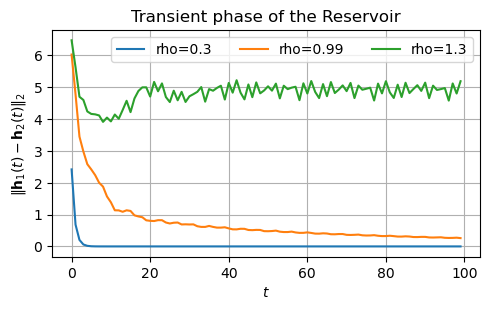

In [47]:
plot_states_evolution(x, rhos, initial_state_0, initial_state_1)

#### Input scaling

- Another critical value is the input scaling $\omega_\text{in}$.
- Is a value that multiplies the input weights $W_i$ changing their magnitude.
- This is key to control the amount of nonlinearity in the model.

- Reservoir units are usually equipped with a $\texttt{tanh}$ activation.
- A small value $\omega_\text{in}$ maps the Reservoir inputs towards the centre of the $\texttt{tanh}$ where is more linear.
- Therefore, a small $\omega_\text{in}$ reduces the amount of nonlinearity in the Reservoir.
- On the other hand, a large $\omega_\text{in}$ translates into a more nonlinear beahvior as the $\texttt{tanh}$ is closer to saturation.

<img src="media/tanh.png" style="width: 30%; display: block; margin: auto;">

- Like for the spectral radius, $\omega_\text{in}$ should be tuned carefully.
- A good starting value is usually around 0.1.

- Another hypeparameter is the number of Reservoir units $N_h$. 
- A larger value can give better performance at the cost of higher computation time.
- A good starting point is usually $N_h=300$, to be increased until there is no more gain in performance.

- There are also other hyperparameters in the ESN, such as the sparsity of the Readout and an optional noise to inject in the state update equation.
- These are usually less critical than $\rho$ and $\omega_\text{in}$ and can be left to their default value in most cases.
- Tuning hyperparameters in randomized architectures such as the ESN is much more important than in trainable neural networks, since there is no training that can compensate for poorly initialized models.

---

## Python example: electricity load forecasting with ESN

- In the following, we will use the [Python library](https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing) `reservoir-computing`. 
- The library allows us to perform time series classification, clustering, and forecasting with Reservoir Computing.
- In this lecture, we will focus on *forecasting*.

### Load the data

We reload the same time series of energy load that we used before.

In [48]:
ts_full = PredLoader().get_data('ElecRome')

# Resample the time series to hourly frequency
ts_hourly = np.mean(ts_full.reshape(-1, 6), axis=1)[:, None]

# Use only the first 3000 time steps
time_series = ts_hourly[0:3000, :]

Loaded ElecRome dataset.
Data shape:
  X: (137376, 1)


- To train the ESN we need input and target data `Xtr` and `Ytr`. 
- We also need test data `Xte` and `Yte` to test the model and validation data `Xval` and `Yval` if we need to do hyperparameters tuning.
- We will use the function `forecasting_datasets` that given a time series `X` does the following computations.

1. Splits the dataset in consecutive chunks: `train`, `val` and `test`. 
   - The size of the chunks is given by the values `val_percent` and `test_percent`. 
   - If we do not need validation data, set `val_percent=0` (default) and the validation data will not be created.

2. Create input data `X` and target data `Y` by shifting the data `horizon` time steps, where `horizon` is how far we want to predict. 
- For example:
    - `Xtr = train[:-horizon,:]`
    - `Ytr = train[horizon:,:]`

1. Normalizes the data using a scaler from `sklearn.preprocessing`. 
   - If no scalers are passed, a `StandardScaler` is created. 
   - The scaler is fit on `Xtr` and then used to transform `Ytr`, `Xval`, and `Xte`. 
   - Note that `Yval` and `Yte` are **not** transformed.

- The code below exemplifies the use of the function.
- Note that we loose some data due to splitting and shifting.

In [49]:
X = np.arange(36)[:, None]
Xtr, Ytr, Xte, Yte, Xval, Yval, scaler = make_forecasting_dataset(X, horizon=5,
                                                                  test_percent=0.2, 
                                                                  val_percent=0.3)
print("Xtr: ", scaler.inverse_transform(Xtr.T)[0])
print("Ytr: ", scaler.inverse_transform(Ytr.T))
print("Xval: ", scaler.inverse_transform(Xval.T)[0])
print("Yval: ", Yval.T)
print("Xte: ", scaler.inverse_transform(Xte.T)[0])
print("Yte: ", Yte.T)

Xtr:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
Ytr:  [[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]]
Xval:  [17. 18. 19. 20. 21. 22.]
Yval:  [[22 23 24 25 26 27]]
Xte:  [28. 29. 30.]
Yte:  [[33 34 35]]


- Back to our real data: we want to make forecast 24h ahead. 
- In a real use case, we must optimize the hyperparameters on a valiation set.
- However, since this is just a demonstration, we will use the default hyperparameters.
- Therefore, we leave the default `val_percent=0` and the validation set is not created.

In [50]:
# Generate training and test datasets
Xtr, Ytr, Xte, Yte, scaler = make_forecasting_dataset(time_series,
                                                      horizon=24, # forecast horizon of 24h ahead
                                                      test_percent = 0.1)
print(f"Xtr shape: {Xtr.shape}\nYtr shape: {Ytr.shape}\nXte shape: {Xte.shape}\nYte shape: {Yte.shape}")

Xtr shape: (2676, 2)
Ytr shape: (2676, 1)
Xte shape: (276, 2)
Yte shape: (276, 1)


### Define the Reservoir and compute the states

- First, we specify the Reservoir hyperparameters and we initialize it.

In [51]:
res= Reservoir(n_internal_units=900,
               spectral_radius=0.99,
               input_scaling=0.1,
               connectivity=0.25)

- Then, we compute the sequence of the Reservoir states `states_tr` and `states_te` associated with the training and test data, respecitvely.
- Since the initial states of the Reservoir mostly depend on the initialization, e.g.,  $\mathbf{h}(0) = [0,0,\dots,0]$, we want to get rid of the initial transient phase.
- This can be done by setting `n_drop` that specifies how many of the initial states we drop.

In [52]:
n_drop=10
states_tr = res.get_states(Xtr[None,:,:], n_drop=n_drop, bidir=False)
states_te = res.get_states(Xte[None,:,:], n_drop=n_drop, bidir=False)
print(f"states_tr shape: {states_tr.shape}\nstates_te shape: {states_te.shape}")

states_tr shape: (1, 2666, 900)
states_te shape: (1, 266, 900)


### Fit a linear readout

- We are now ready to train the readout to predict the desired output given the sequence of Reservoir states.
- We start by using a linear readout implemented by a Ridge regressor.
- After the readout is trained, we use it to compute the predictions $\hat{Y}_\text{te}$ of the test data.

In [53]:
# Fit the ridge regression model
ridge = Ridge(alpha=1.0) 
time_start = time.time()
ridge.fit(states_tr[0], Ytr[n_drop:,:])
print(f"Training time: {time.time()-time_start:.4f}s")

# Compute the predictions
time_start = time.time()
Yhat = ridge.predict(states_te[0])
print(f"Test time: {time.time()-time_start:.4f}s")

Training time: 0.0193s
Test time: 0.0004s


- Finally, we plot the results and compute the MSE.

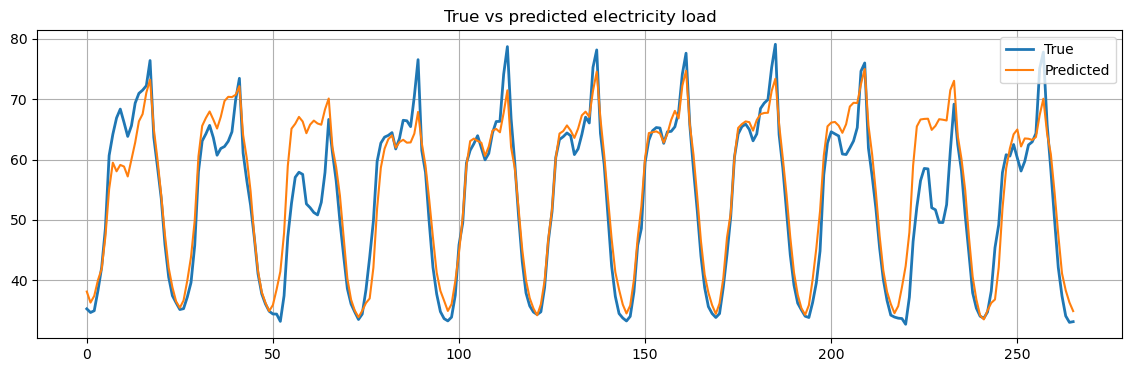

In [54]:
fig = plt.figure(figsize=(14,4))
plt.plot(Yte[n_drop:,:], label="True", linewidth=2)
plt.plot(scaler.inverse_transform(Yhat.reshape(-1, 1)), label="Predicted")
plt.grid()
plt.legend()
plt.title("True vs predicted electricity load")
plt.show()

In [56]:
mse = mean_squared_error(scaler.inverse_transform(Yhat.reshape(-1, 1)), Yte[n_drop:,:])
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 23.94


### Reducing the dimensionality of the Reservoir states

- As discussed earlier, the Reservoir states contain a rich, yet often redundant, pool of dynamics.
- The readout job is to select only the dynamics that are useful for the task at hand.
- However, training a readout on high-dimensional states is computational demanding, especially when using a sophisticated readout.
- In addition, working with high dimensional data can increase the risk of multicollinearity, which destabilizes certain models, and overfitting.

- It can be desirable reducing to some extent the redundancy in the Reservoir states.
- This can be done with an unsupervised dimensionality reduction procedure.
- The most common and efficient dimensionality reduction procedure is PCA.

#### Principal Component Analysis (PCA)
- PCA is a statistical procedure that utilizes an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called *principal components*. 
- The number of principal components is less than or equal to the number of original variables. 
- By using a few components, PCA reduces the dimensionality of large data sets, by projecting the data onto a lower-dimensional space with minimal loss of information.

- Our data is a sequence of length $T$ of Reservoir states, each one of size $N_h$. 
- They can be arranged in a matrix $\mathbf{H} \in \mathbb{R}^{T \times N_h}$.
- To illustrate the procedure, let's first consider a toy example with only $N_h = 3$ features.
- In addition, we will create some structure in the data, by dividing the samples in 4 groups/clusters.
- This will help us to see how PCA preserves the structure in the data.

In [57]:
# Generate 4 clusters of points in 3 dimensions
T = 300 # number of samples
N_h = 3 # number of features
H, clust_id = make_blobs(n_samples=T, n_features=N_h, 
                         centers=4, cluster_std=1.5, random_state=1)

In [58]:
def plot_data(H, clust_id, interactive=False):
    if interactive:
        fig = go.Figure(data=[
            go.Scatter3d(x=H[:, 0], y=H[:, 1], z=H[:, 2], mode='markers', 
            marker=dict(size=5, opacity=0.5, color=clust_id, colorscale='Viridis')),
        ])
        fig.update_layout(scene=dict(xaxis_title='X Axis',
                                     yaxis_title='Y Axis',
                                     zaxis_title='Z Axis',
                                     zaxis=dict(range=[-20, 10])),
                          margin=dict(l=0, r=0, b=0, t=0),
                          width=400, height=400 
                        )
        fig.show()
    else:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(xs=H[:, 0], ys=H[:, 1], zs=H[:, 2], linewidth=0.2, alpha=0.7, c=clust_id)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_zticks(())
        plt.show()

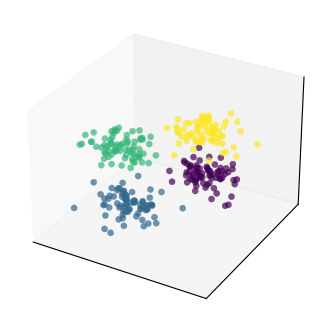

In [59]:
# Set interactive = True to get an interactive plot that can be rotated
plot_data(H, clust_id, interactive=False) 

Reducing the data dimensionality with PCA invole the following steps:

1. **Standardization** 
- Scale the data so that each feature has a mean of 0 and a standard deviation of 1. 
- This is important because PCA is affected by scale.

2. **Covariance matrix computation**: 
- Calculate the empirical covariance matrix $\mathbf{H}^T\mathbf{H}$.
- The matrix shows how changes in one variable are associated with changes in another variable.

3. **Eigenvalues and eigenvectors computation**
- The eigenvectors of the covariance matrix represent the directions of maximum variance.
- In the context of PCA, the eigenvectors are the principal components.
- The eigenvalues indicate the variance explained by each principal component.

4. **Sorting eigenvectors**:

- The eigenvectors are sorted by decreasing eigenvalues. 
- The top-$k$ eigenvectors are selected, where $k$ is the number of dimensions we want to keep.
- In our case, we keep $k=2$ dimensions.

5. **Projection onto the new feature space**: 
- The original data are projected onto the selected principal components.
- In our case, the 3-dimensional data are projected onto the plane spanned by the first two principale components.
- The projected data are the reduced-dimensional data.

In [60]:
# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
H_pca = pca.fit_transform(H)
v1, v2 = pca.components_

In [61]:
def plot_pca_plane(H, clust_id, v1, v2, interactive=False):
    mean = np.mean(H, axis=0)
    length = np.linspace(-15, 15, 20)
    another_length = np.linspace(-15, 15, 20)
    xx, yy = np.meshgrid(length, another_length)

    def compute_z(x, y, v1, v2, mean):
        z = np.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                point_in_plane = mean + v1 * x[i, j] + v2 * y[i, j]
                z[i, j] = point_in_plane[2]
        return z
    Z_grid = compute_z(xx, yy, v1, v2, mean)
    
    if interactive:
        fig = go.Figure(data=[
            go.Surface(z=Z_grid, x=xx, y=yy, colorscale='gray', opacity=0.5, showscale=False),
            go.Scatter3d(x=H[:, 0], y=H[:, 1], z=H[:, 2], mode='markers', 
                         marker=dict(size=5, opacity=0.5, color=clust_id, colorscale='Viridis'))])
        fig.update_layout(scene=dict(xaxis_title='X Axis',
                                     yaxis_title='Y Axis',
                                     zaxis_title='Z Axis',
                                     zaxis=dict(range=[-20, 20])),
                          margin=dict(l=0, r=0, b=0, t=0),
                          width=400, height=400)
        fig.show()
    else:
        fig = plt.figure(figsize=(5, 5)) 
        ax = fig.add_subplot(111, projection='3d')

        surf = ax.plot_surface(xx, yy, Z_grid, cmap='gray', edgecolor='none', alpha=0.5)
        ax.scatter3D(xs=H[:, 0], ys=H[:, 1], zs=H[:, 2], linewidth=0.2, alpha=0.7, c=clust_id)
        ax.view_init(elev=20, azim=20)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_zticks(())
        plt.show()

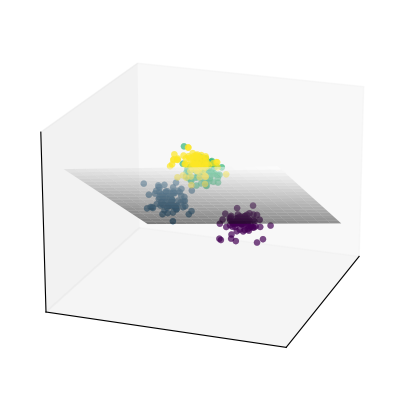

In [62]:
# Plot the hyperplane spanned by the first two principal components
plot_pca_plane(H, clust_id, v1, v2, interactive=False)

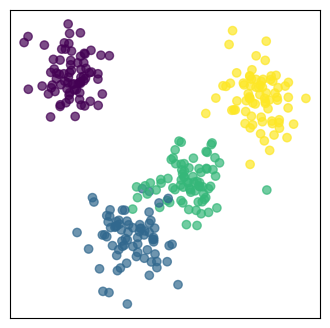

In [63]:
# Plot the 2D projection
plt.figure(figsize=(4, 4))
plt.scatter(H_pca[:, 0], H_pca[:, 1], c=clust_id, cmap='viridis', alpha=0.7)
plt.xticks([], []), plt.yticks([], [])
plt.show()

- We can further reduce the number of dimensions. 
- In this case, we can go down to 1 dimension.
- It boils down to projecting the data into the direction of maximum variation.

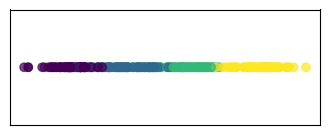

In [64]:
H_pca_1d = PCA(n_components=1).fit_transform(H)

# Plot the 1D projection
plt.figure(figsize=(4, 1.5))
plt.scatter(H_pca_1d, np.zeros_like(H_pca_1d), c=clust_id, cmap='viridis', alpha=0.7)
plt.xticks([], []), plt.yticks([], [])
plt.show()

- 💡 Check [this blog](https://setosa.io/ev/principal-component-analysis/) for an excellent visual explanation and interactive examples about PCA.

#### Reducing the dimensionality of the Reservoir states

- Let's go back to our Reservoir states, which in our case are very high-dimensional vectors. 
- In particular, since `n_internal_units=900`, we end up with a sequence of length `T` of vectors with size `900`.
- We will use PCA to reduce the dimension of the reservoir states to `75`.

In [65]:
pca = PCA(n_components=75)
states_tr_pca = pca.fit_transform(states_tr[0])
states_te_pca = pca.transform(states_te[0])
print(f"states_tr shape: {states_tr_pca.shape}\nstates_te shape: {states_te_pca.shape}")

states_tr shape: (2666, 75)
states_te shape: (266, 75)


- Below, we fit the readout on the new data and compute the results on the test set.

In [67]:
# Fit the ridge regression model
ridge = Ridge(alpha=1.0) 
time_start = time.time()
ridge.fit(states_tr_pca, Ytr[n_drop:,:])
print(f"Training time: {time.time()-time_start:.4f}s")

# Compute the predictions
time_start = time.time()
Yhat_pca = ridge.predict(states_te_pca)
print(f"Test time: {time.time()-time_start:.4f}s")

# Compute the mean squared error
mse = mean_squared_error(scaler.inverse_transform(Yhat_pca.reshape(-1, 1)), Yte[n_drop:,:])
print(f"Mean Squared Error: {mse:.2f}")

Training time: 0.0017s
Test time: 0.0002s
Mean Squared Error: 23.95


- Even with a drastic reduction of the dimensionality, the performance remained more or less unchanged.
- On the other hand, we reduce the computation time both in training and in test.
- This reduction in computing time is particularly significant when using more sophisticated readouts, like the one we will try next.

### Fit a GBRT readout

- Mapping the Reservoir states to the desired output is a standard regression problem, which can be solved by one of the many standard regression models in [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html).
- For example, we can use a Gradient Boost Regression Tree (GBRT), which gives us predictions for different quantiles.
- In this way, we can compute confidence intervals in our predictions.
- This is a very simple way to implement probabilistic forecasting.

- In the following, we will fit a different model for the 0.5, 0.05 and 0.95 quantiles.
- The 0.5 quantile will give us the most likely prediction for the future values.
- The 0.05 and 0.95 quantiles together will us a 90\% confidence interval for our prediction.

In [68]:
time_start = time.time()

# Quantile 0.5
max_iter = 100
gbrt_median = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.5, max_iter=max_iter)
gbrt_median.fit(states_tr[0], Ytr[n_drop:,0])
median_predictions = gbrt_median.predict(states_te[0])

# Quantile 0.05
gbrt_percentile_5 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.05, max_iter=max_iter)
gbrt_percentile_5.fit(states_tr[0], Ytr[n_drop:,0])
percentile_5_predictions = gbrt_percentile_5.predict(states_te[0])

# Quantile 0.95
gbrt_percentile_95 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.95, max_iter=max_iter)
gbrt_percentile_95.fit(states_tr[0], Ytr[n_drop:,0])
percentile_95_predictions = gbrt_percentile_95.predict(states_te[0])

print(f"Training time: {time.time()-time_start:.2f}s")

Training time: 3.42s


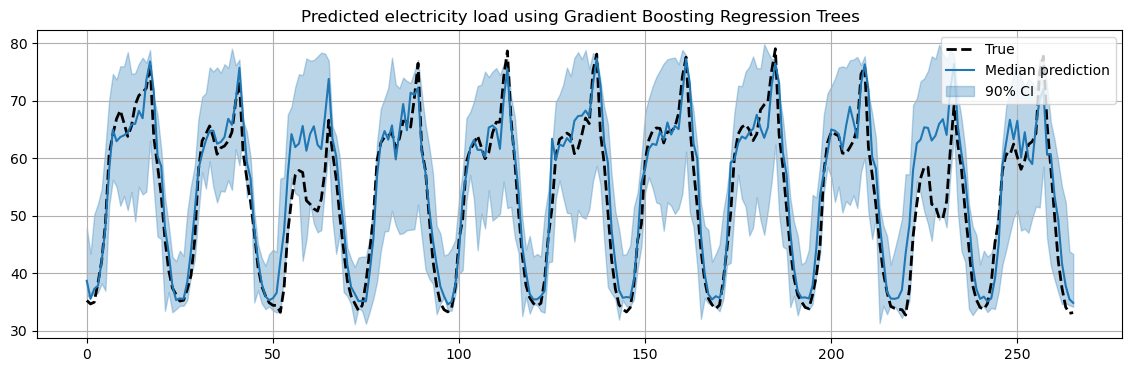

In [69]:
# Plot the results
fig = plt.figure(figsize=(14,4))
plt.plot(Yte[n_drop:,:], 'k--', label="True", linewidth=2)
plt.plot(scaler.inverse_transform(median_predictions[:,None]), label="Median prediction", color="tab:blue")
plt.fill_between(np.arange(len(Yte[n_drop:,:])), scaler.inverse_transform(percentile_5_predictions[:,None]).ravel(), scaler.inverse_transform(percentile_95_predictions[:,None]).ravel(), alpha=0.3, label="90% CI", color="tab:blue")
plt.grid()
plt.legend()
plt.title("Predicted electricity load using Gradient Boosting Regression Trees")
plt.show()

- Finally, we repeat the training on the states reduced with PCA.

In [70]:
time_start = time.time()

# Quantile 0.5
max_iter = 100
gbrt_median = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.5, max_iter=max_iter)
gbrt_median.fit(states_tr_pca, Ytr[n_drop:,0])
median_predictions = gbrt_median.predict(states_te_pca)

# Quantile 0.05
gbrt_percentile_5 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.05, max_iter=max_iter)
gbrt_percentile_5.fit(states_tr_pca, Ytr[n_drop:,0])
percentile_5_predictions = gbrt_percentile_5.predict(states_te_pca)

# Quantile 0.95
gbrt_percentile_95 = HistGradientBoostingRegressor(
    loss="quantile", quantile=0.95, max_iter=max_iter)
gbrt_percentile_95.fit(states_tr_pca, Ytr[n_drop:,0])
percentile_95_predictions = gbrt_percentile_95.predict(states_te_pca)

print(f"Training time: {time.time()-time_start:.2f}s")

Training time: 1.11s


- The improvement in terms of computing time now is significant.

## Summary

In this lecture we saw:

- Neural Networks, the MLP, and how it can be used as a windowed model to perform time series forecasting.
- The limitation of windowed approaches and how they can be solved by RNNs.
- The ESN, a randomized RNN from the family of Reservoir Computing approaches that is fast and easy to train.
- Examples of forecasting with MLP and ESN on real-world electricity data.

---

## Exercises

### Exercise 1

- In the MLP example, change the `window_size` ($P$) from 12 to 24. 
- Comment on the results and explain why the performance improve. 

### Exercise 2
- In the MLP, change `forecast_horizon` from 24 to 36.
- Do the same change also in the ESN.
- With a forecast horizon of size 24 we used as a baseline the MSE between the time series and its shifted version by 24 lags, `mse = mean_squared_error(y_test[24:], y_test[:-24])`. Is this a good baseline also when the forecast horizon changes? What could be a better baseline?


### Exercise 3

Contrarily from model-based approach such as ARIMA, the MLP and the ESN do not strctly require the data to be stationary. However, by removing trend and seasonality the MLP and the ESN can focus only on predicting the residuals.

- Remove trend and seasonality and train both MLP and ESN to train the residuals. 
- In testing, remember to put back the trend and seasonality when computing the predictions.
- Compare the results with those obtained by training the MLP and the ESN on the original data.

### Exercise 4

For this exercise, we will consider a new dataset consisting of hourly water temperatures from Gulf of Mexico near Key West, Florida. 
The hourly temperatures are provided from October 3, 2016 to October 3, 2017
The dataset consists of a data frame with 6572 observations on the following 3 variables.

- `DateTime` Date and time of reading (format mm/dd/yyyy h:00).
- `WaterTemp`: Water temperature (in degrees Fahrenheit).
- `t`: Time index (1 to 673).

Raw data:
------------------
          DateTime  WaterTemp  t
0  10/3/2016 0:00       86.2  1
1  10/3/2016 1:00       86.2  2
2  10/3/2016 2:00       86.2  3
3  10/3/2016 3:00       86.2  4
4  10/3/2016 4:00       86.0  5


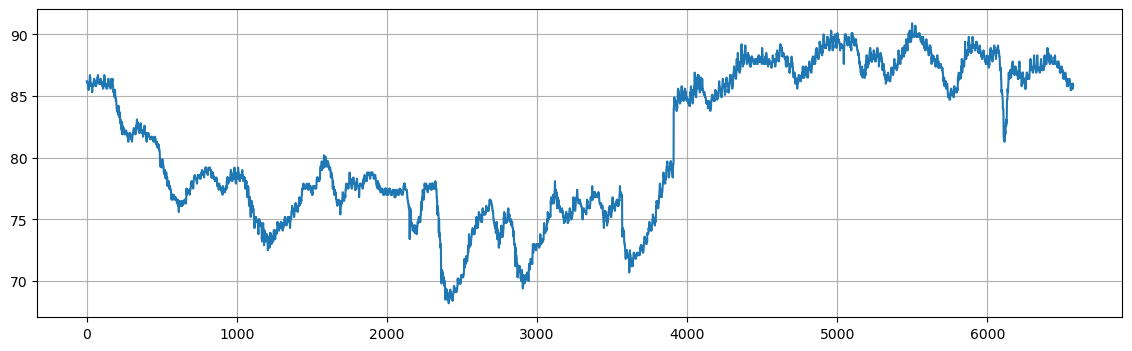

In [71]:
temps = sm.datasets.get_rdataset("KeyWestWater", "Stat2Data").data
print("Raw data:\n------------------\n", temps.head())
plt.figure(figsize=(14,4))
plt.plot(temps["WaterTemp"])
plt.grid()
plt.show()

- Apply the MLP on the temperature data.
- Perform a small grid search to try different values for the following hyperparameters:
    - `hidden_layer_sizes` (e.g., try more layers `[16, 16, 8]`, layers with more units `[32, 16]`, etc...).
    - `learning_rate_init`.
    - `activation` (try at least `tanh` and `relu`).
- Apply the ESN on the temperature data.
- Perform a small grid search to try different values for the following hyperparameters:
    - `spectral_radius`.
    - `input_scaling`.
    - `n_internal_units`.
    - `connectivity`.

Report the configuration of MLP and ESN that achieves the best performance on the test data.